## Attention Unet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the dataset
!unzip /content/drive/MyDrive/Cotton_project/final/final_data.zip -d /content/final_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/final_data/final_data/images/20221109_lbk_p4r_twri_mosaic3292.jpg  
  inflating: /content/final_data/__MACOSX/final_data/images/._20221109_lbk_p4r_twri_mosaic3292.jpg  
  inflating: /content/final_data/final_data/images/20221109_lbk_p4r_twri_mosaic2832.jpg  
  inflating: /content/final_data/__MACOSX/final_data/images/._20221109_lbk_p4r_twri_mosaic2832.jpg  
  inflating: /content/final_data/final_data/images/20221109_lbk_p4r_twri_mosaic5813.jpg  
  inflating: /content/final_data/__MACOSX/final_data/images/._20221109_lbk_p4r_twri_mosaic5813.jpg  
  inflating: /content/final_data/final_data/images/20221109_lbk_p4r_twri_mosaic5152.jpg  
  inflating: /content/final_data/__MACOSX/final_data/images/._20221109_lbk_p4r_twri_mosaic5152.jpg  
  inflating: /content/final_data/final_data/images/20221109_lbk_p4r_twri_mosaic1452.jpg  
  inflating: /content/final_data/__MACOSX/final_data/images/._20221109_lbk_p4r_twri_mosaic1452.

In [ ]:
import os
import zipfile
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

An Attention U-Net is a specialized type of neural network that integrates attention mechanisms into the U-Net architecture. U-Nets are primarily used for image segmentation tasks. By adding attention mechanisms, the Attention U-Net can more effectively focus on relevant parts of the image, leading to better segmentation performance. It captures the low level spatial information and merges with the layers from deeper part of network that has feature information. It is then passed through relu and sigmoid function to assign weights to it


In [ ]:
cd /content/drive/MyDrive/Mentor\ students

/content/drive/MyDrive/Mentor students


## Importing Libraries

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

##Dataset Preparation

In [ ]:

def load_images(directory_path, resize_shape=(128, 128)):
    image_list = []
    files = sorted(os.listdir(directory_path))

    for file in files:
        img_path = os.path.join(directory_path, file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, resize_shape)
        image_list.append(img)

    return np.array(image_list)

# Loading original images and masks
image_folder = '/content/final_data/final_data/images'
mask_folder = '/content/final_data/final_data/mask'

images = load_images(image_folder)
masks = load_images(mask_folder)


def convert_to_binary(masks):
    binary_masks = []
    for mask in masks:
        gray_mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        _, binary_mask = cv2.threshold(gray_mask, 127, 255, cv2.THRESH_BINARY)
        binary_masks.append(binary_mask)
    return np.array(binary_masks)

masks = convert_to_binary(masks)

# Spliting data into training and testing sets (80% training, 20% testing)
src_images, src_test_images, tar_images, tar_test_images = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f'Training images: {len(src_images)}, Testing images: {len(src_test_images)}')

Training images: 1493, Testing images: 374


In [ ]:
# def load_images(directory_path, resize_shape=(128, 128)):
#     files = sorted(os.listdir(directory_path))
#     image_list = []

#     for file in files:
#         img_path = os.path.join(directory_path, file)
#         img = cv2.imread(img_path)
#         img = cv2.resize(img, resize_shape)
#         image_list.append(img)

#     images = np.array(image_list)
#     return images

# # Example usage:
# src_images = load_images('Janvita/Yield_Prediction/Object_detection/Train_images')
# tar_images = load_images('Janvita/Yield_Prediction/Object_detection/Train_mask')
# src_test_images = load_images('Janvita/Yield_Prediction/Object_detection/Test_images')
# tar_test_images = load_images('Janvita/Yield_Prediction/Object_detection/Test_mask')

In [ ]:
import matplotlib.pyplot as plt

def check_if_grayscale(images, idx=0):
    """
    Check if a single image (by index) is grayscale or RGB.
    """

    img = images[idx]

    print(f"Image {idx} shape: {img.shape}")

    # Checking if the image has 3 channels (RGB)
    if len(img.shape) == 3 and img.shape[2] == 3:
        print(f"Image {idx} is RGB.")
    else:
        print(f"Image {idx} is Grayscale.")


    plt.imshow(img, cmap='gray' if len(img.shape) == 2 or img.shape[2] == 1 else None)
    plt.title(f"Image {idx}")
    plt.axis('off')
    plt.show()


Checking 1 image from the training images (src_images):
Image 2 shape: (128, 128, 3)
Image 2 is RGB.


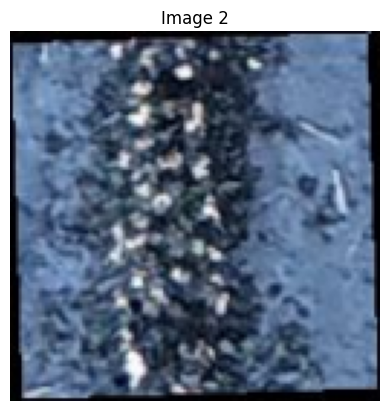

Checking 1 mask from the training masks (tar_images):
Image 2 shape: (128, 128)
Image 2 is Grayscale.


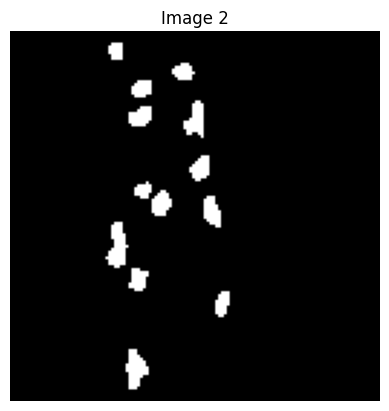

In [ ]:
# Checking  1 image from the training images (src_images)
print("Checking 1 image from the training images (src_images):")
check_if_grayscale(src_images, idx=2)

# Checking  1 mask from the training masks (tar_images)
print("Checking 1 mask from the training masks (tar_images):")
check_if_grayscale(tar_images, idx=2)

In [ ]:
import numpy as np
import cv2

def normalize_grayscale_masks(tar_images):
    """
    Normalize both grayscale and RGB masks to binary (0 and 1).
    This function handles both grayscale and RGB images.
    """
    binary_tar_images = []

    for image in tar_images:

        if len(image.shape) == 3 and image.shape[2] == 3:
            gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray_image = image


        _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)


        binary_image = binary_image / 255.0


        binary_image = np.expand_dims(binary_image, axis=-1)


        binary_tar_images.append(binary_image)

    return np.array(binary_tar_images)

In [ ]:
# Normalizing training masks
tar_images = normalize_grayscale_masks(tar_images)

# Normalizing testing masks
tar_test_images = normalize_grayscale_masks(tar_test_images)


##Model

In [ ]:
def conv_block(x,num_filters):
  x = L.Conv2D(num_filters,3,padding = 'same')(x)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x)

  x = L.Conv2D(num_filters,3,padding = 'same')(x)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x)

  return x

In [ ]:
def encoder_block(x,num_filters):
  x = conv_block(x,num_filters)
  p = L.MaxPool2D((2,2))(x)
  return x,p


In [ ]:
def decoder_block(x,s,num_filters):
  x = L.UpSampling2D(interpolation = 'bilinear')(x)
  s = attention_gate(x,s,num_filters)
  x = L.Concatenate()([x,s])
  x = conv_block(x,num_filters)
  return x


In [ ]:
def attention_gate(g,s,num_filters):
  Wg = L.Conv2D(num_filters,1,padding = 'same')(g)
  Wg = L.BatchNormalization()(Wg)

  Ws = L.Conv2D(num_filters,1,padding = 'same')(s)
  Ws = L.BatchNormalization()(Ws)

  out = L.Activation('relu')(Wg + Ws)
  out = L.Conv2D(num_filters,1,padding = 'same')(out)
  out = L.Activation('sigmoid')(out)

  return s*out

In [ ]:
def attention_unet(input_shape):
  inputs = L.Input(input_shape)
  s1,p1 = encoder_block(inputs,16)
  s2,p2 = encoder_block(p1,32)
  s3,p3 = encoder_block(p2,64)
  s4,p4 = encoder_block(p3,128)
  s5,p5 = encoder_block(p4,256)


  b1 = conv_block(p5,512)

  d1 = decoder_block(b1,s5,256)
  d2 = decoder_block(d1,s4,128)
  d3 = decoder_block(d2,s3,64)
  d4 = decoder_block(d3,s2,32)
  d5 = decoder_block(d4,s1,16)


  outputs = L.Conv2D(1,1,padding = 'same',activation = 'sigmoid')(d5)
  model = Model(inputs, outputs)
  return model

## Training

In [ ]:
model = attention_unet((128,128,3))

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_true_f = tf.cast(y_true_f, tf.float32)  # Cast y_true_f to float32
    y_pred_f = K.flatten(y_pred)
    y_pred_f = tf.cast(y_pred_f, tf.float32)  # Cast y_pred_f to float32 to ensure type consistency
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 0.00001) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 0.00001)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1e-5):
    y_true_f = K.flatten(y_true)
    y_true_f = tf.cast(y_true_f, tf.float32)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    focal_loss = -alpha * K.pow(1 - p_t, gamma) * K.log(p_t)
    return K.mean(focal_loss)

def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    focal = focal_loss(y_true, y_pred)

    # You can adjust the weights to balance the contributions of each loss term
    combined = 0.5 * dice + 0.5 * focal

    return combined

# Example usage in model compilation



In [ ]:
model.compile(optimizer = 'adam',loss = [combined_loss],metrics = [jacard_coef])

In [ ]:
model.fit(src_images,tar_images,validation_split = 0.1,batch_size = 5,epochs = 100)

Epoch 1/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 75s 116ms/step - jacard_coef: 0.2813 - loss: 0.2979 - val_jacard_coef: 0.5073 - val_loss: 0.1755
Epoch 2/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - jacard_coef: 0.6137 - loss: 0.1285 - val_jacard_coef: 0.6621 - val_loss: 0.1116
Epoch 3/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - jacard_coef: 0.6679 - loss: 0.1094 - val_jacard_coef: 0.6730 - val_loss: 0.1077
Epoch 4/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - jacard_coef: 0.6850 - loss: 0.1027 - val_jacard_coef: 0.6761 - val_loss: 0.1060
Epoch 5/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - jacard_coef: 0.6945 - loss: 0.0989 - val_jacard_coef: 0.6786 - val_loss: 0.1058
Epoch 6/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - jacard_coef: 0.6950 - loss: 0.0986 - val_jacard_coef: 0.6890 - val_loss: 0.1013
Epoch 7/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - jacard_coef: 0.6977 - loss: 0.0984 - val_jacard_coef: 0.6926 - val_loss: 0.1003
Epoch 8/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 

##Inferenence

In [ ]:
pred = model.predict(src_test_images)

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 428ms/step


In [ ]:
dice_coef(tar_test_images,pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8230123>

In [ ]:
jacard_coef(tar_test_images,pred)


<tf.Tensor: shape=(), dtype=float32, numpy=0.6992531>

In [ ]:
pred = (model.predict(src_test_images) * 255).astype(np.uint8)
pred = np.squeeze(pred, axis=-1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


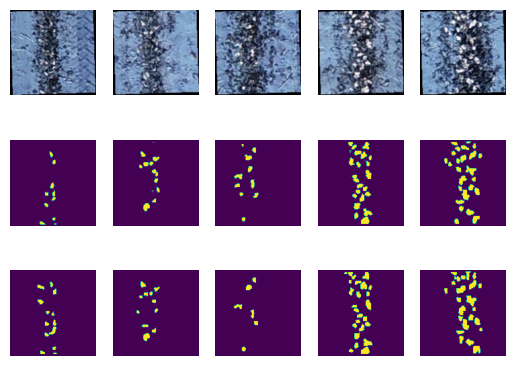

In [ ]:
n_samples = 5

# Assuming 'expected' contains your ground truth images and 'pred' contains predicted images
for i in range(n_samples):
    # Plot actual image
    plt.subplot(3, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(src_test_images[i].astype('uint8'))


    # Plot predicted image
    plt.subplot(3, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(pred[i].astype('uint8'))

    # Plot expected image
    plt.subplot(3, n_samples, 1 + 2 * n_samples + i)
    plt.axis('off')
    plt.imshow(tar_test_images[i].astype('uint8'))

plt.show()

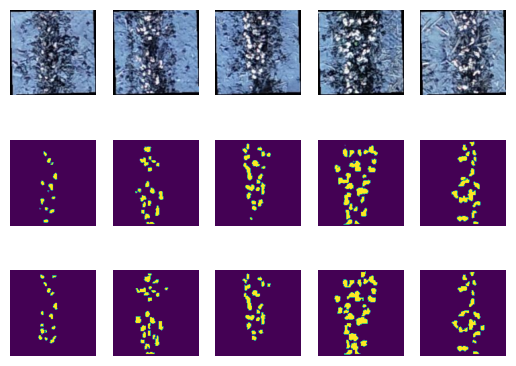

In [ ]:
n_samples = 5

# Assuming 'expected' contains your ground truth images and 'pred' contains predicted images
for i in range(n_samples):
    # Plot actual image
    plt.subplot(3, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(src_test_images[5 + i].astype('uint8'))


    # Plot predicted image
    plt.subplot(3, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(pred[5 + i].astype('uint8'))

    # Plot expected image
    plt.subplot(3, n_samples, 1 + 2 * n_samples + i)
    plt.axis('off')
    plt.imshow(tar_test_images[5 + i].astype('uint8'))

plt.show()